# Single-cell RNA Sequencing Analysis - Data Wrangling

## 1. Introduction

In recent years, the field of single-cell genomics has witnessed an unprecedented level of growth, pushing the boundaries of our biological understanding. The ability to measure and analyze individual cells' DNA, RNA, and protein constitution has allowed for an in-depth view of complex biological systems, yielding insights into processes such as human embryonic development, novel disease-associated cell types, and potential cell-targeted therapeutic interventions. Machine learning models can reveal unique characteristics of individual cells, providing insights into how gene regulation affects blood and immune cell differentiation and maturation over time.

This project seeks to delve further into this rich biological data by employing advanced machine-learning models to explore how these genetic factors co-vary as bone marrow stem cells mature into blood cells.

While we have come a long way in single-cell genomic research, the analysis methods for multimodal single-cell data remain insufficient, especially considering the temporal dynamics alongside state changes over time. This leaves us with a knowledge gap in comprehending how genetic information flows and regulates dynamic cellular processes such as cell differentiation and maturation. This project addresses this by investigating **how DNA, RNA, and protein measurements co-vary in single cells as bone marrow stem cells develop into more mature blood cells.**

In cellular processes, a specific sequence of data transfer is evident. For proteins to be synthesized, DNA must be reachable, allowing RNA formation. This RNA then becomes the foundation for constructing proteins. Given this sequence, we can theorize that if we understand the availability of DNA, we might anticipate subsequent RNA patterns, and similarly, RNA data might hint at upcoming protein counts. In our current study, we're focusing on understanding the intricate connections among `DNA`, `RNA`, and `proteins`. 

It's essential to highlight that our data collection tools don't capture all these elements at the same time. We rely on two distinct testing techniques. The first goes by the name `10x Chromium Single Cell Multiome ATAC + Gene Expression`, or for brevity, `multiome`. The second is referred to as the `10x Genomics Single Cell Gene Expression with Feature Barcoding system`, or in short, `citeseq`.

Using the multiome technique, we can gauge DNA availability and RNA output levels, whereas the citeseq approach allows us to evaluate RNA outputs and external protein counts.

This means we obtain insights about DNA's reachability and external proteins only once (from the multiome and citeseq techniques respectively), but we collect RNA output information from both techniques. Now, let's delve into the specifics of the data representation.

**In this project, we will focus on CITEseq technique.** 

In this notebook, we will perform the data wrangling stages. 

In [72]:
!pip install --quiet tables

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

## 2. Loading Data

In [120]:
# set paths
data_path = './Data'
cell_metadata = os.path.join(data_path,'metadata.csv')

cite_train_inputs = os.path.join(data_path,'train_cite_inputs.h5')
cite_train_targets = os.path.join(data_path,'train_cite_targets.h5')
cite_test_inputs = os.path.join(data_path,'test_cite_inputs.h5')


## 3. Data Wrangling

In [74]:
data_meta = pd.read_csv(cell_metadata, index_col='cell_id')
data_meta.head()

,day,donor,cell_type,technology
cell_id,,,,
c2150f55becb,2,27678,HSC,citeseq
65b7edf8a4da,2,27678,HSC,citeseq
c1b26cb1057b,2,27678,EryP,citeseq
917168fa6f83,2,27678,NeuP,citeseq
2b29feeca86d,2,27678,EryP,citeseq


In [75]:
data_meta.info()

<class 'pandas.core.frame.DataFrame'>
Index: 281528 entries, c2150f55becb to b847ba21f59f
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   day         281528 non-null  int64 
 1   donor       281528 non-null  int64 
 2   cell_type   281528 non-null  object
 3   technology  281528 non-null  object
dtypes: int64(2), object(2)
memory usage: 10.7+ MB


In [76]:
data_meta.shape

(281528, 4)

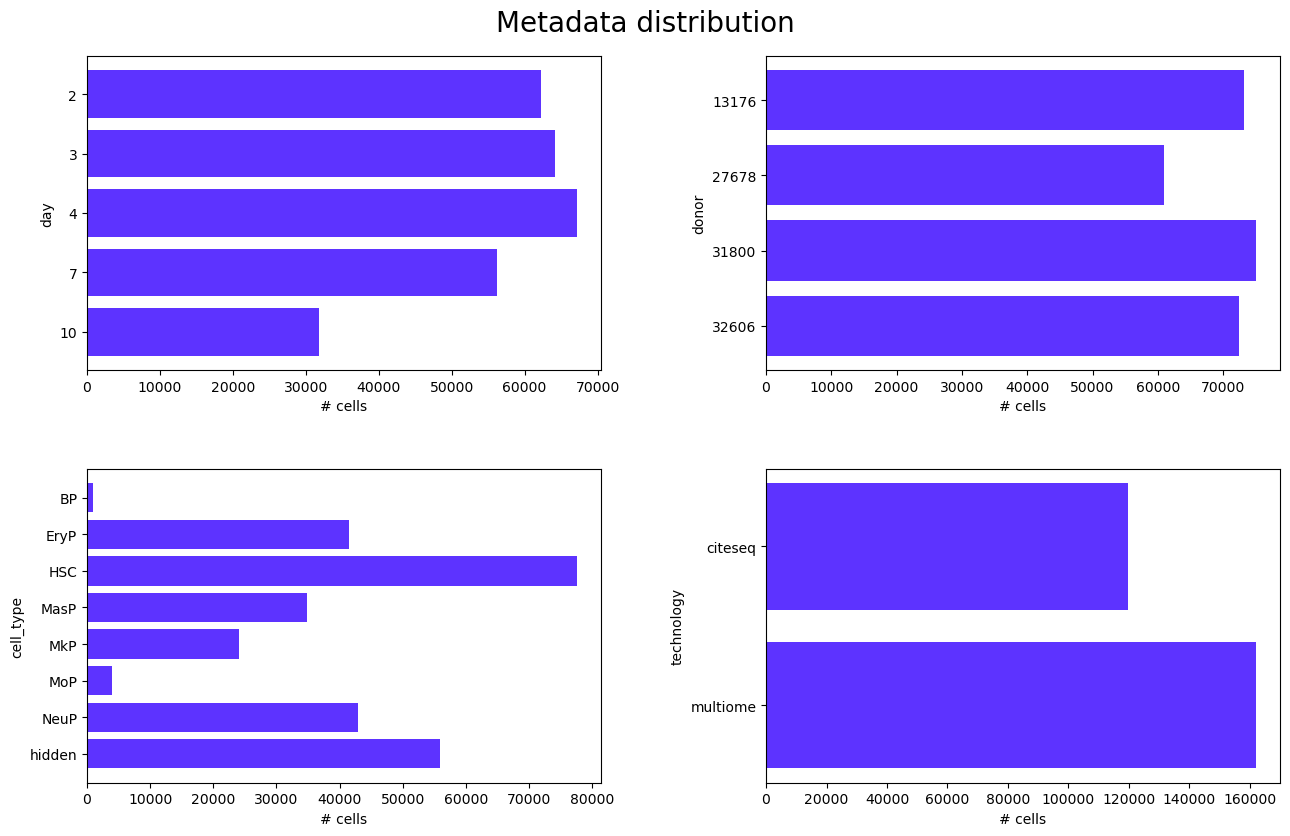

In [109]:
def plot_metadata_distribution(data, column, ax):
    value_counts = data[column].astype(str).value_counts()
    
    # Sort based on the column type
    if column == 'day':
        value_counts.sort_index(key=lambda x: x.astype(int), ascending=False, inplace=True)
    else:
        value_counts.sort_index(ascending=False, inplace=True)
        
    ax.barh(value_counts.index, value_counts, color='#5D33FF')
    ax.set_ylabel(column)
    ax.set_xlabel('# cells')

def visualize_metadata_distribution(data_meta):
    fig, axs = plt.subplots(2, 2, figsize=(13, 8))
    
    metadata_columns = ['day', 'donor', 'cell_type', 'technology']
    for column, ax in zip(metadata_columns, axs.ravel()):
        plot_metadata_distribution(data_meta, column, ax)
    
    plt.tight_layout(h_pad=4, w_pad=4)
    plt.suptitle('Metadata distribution', y=1.04, fontsize=20)
    plt.show()

visualize_metadata_distribution(data_meta)


The CITEseq measurements took place on four days, the Multiome measurements on five

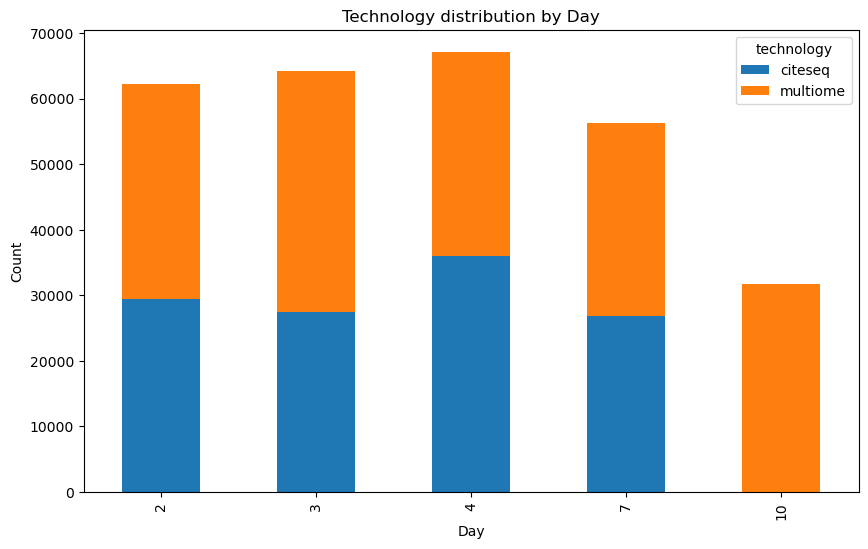

In [110]:
ct = pd.crosstab(data_meta['day'], data_meta['technology'])
ct.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Technology distribution by Day')
plt.ylabel('Count')
plt.xlabel('Day')
plt.show()

The CITEseq measurements occurred on four days (days 2, 3, 4 and 7), while the Multiome measures were on five (days 2, 3, 4, 7 and 10). 

In [77]:
#Counts of null values 
na_df=pd.DataFrame(data_meta.isnull().sum().sort_values(ascending=False)).reset_index()
na_df.columns = ['VarName', 'NullCount']
na_df[(na_df['NullCount']>0)]

,VarName,NullCount


In [78]:
# Duplicates 
data_meta.index.duplicated().any()

False

In [79]:
unique_counts, index_unique_count = data_meta.nunique(), data_meta.index.nunique()
unique_counts, index_unique_count

(day           5
 donor         4
 cell_type     8
 technology    2
 dtype: int64,
 281528)

Therefore, the metadata dataset, which contains training and test dataset has `281528` unique cell_id. 

The cells belong to `5 days`, `4 donors`, `8 cell types`, and `2 technologies`.

The metadata table has no missing values.


In [80]:
data_meta_cite = data_meta[data_meta['technology'] == 'citeseq']
data_meta_multi = data_meta[data_meta['technology'] == 'multiome']

In [81]:
data_meta_cite.shape

(119651, 4)

In [82]:
data_meta_multi.shape

(161877, 4)

Hence, there are `119651` and `161877` records (`cell_id`) in CITEseq and Multiome input dataset, respectively. 

### 3.1 CITEseq Input Dataset 

Now let's start by looking at CITEseq input data for training. 

In [83]:
data_cite_train_X = pd.read_hdf(cite_train_inputs)
data_cite_train_X.head()

gene_id,ENSG00000121410_A1BG,ENSG00000268895_A1BG-AS1,ENSG00000175899_A2M,ENSG00000245105_A2M-AS1,ENSG00000166535_A2ML1,ENSG00000128274_A4GALT,ENSG00000094914_AAAS,ENSG00000081760_AACS,ENSG00000109576_AADAT,ENSG00000103591_AAGAB,...,ENSG00000153975_ZUP1,ENSG00000086827_ZW10,ENSG00000174442_ZWILCH,ENSG00000122952_ZWINT,ENSG00000198205_ZXDA,ENSG00000198455_ZXDB,ENSG00000070476_ZXDC,ENSG00000162378_ZYG11B,ENSG00000159840_ZYX,ENSG00000074755_ZZEF1
cell_id,,,,,,,,,,,,,,,,,,,,,
45006fe3e4c8,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.00000,0.000000,4.090185,0.0
d02759a80ba2,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,4.039545,0.0,0.0,0.00000,0.000000,0.000000,0.0
c016c6b0efa5,0.0,0.0,0.0,0.0,0.0,3.847321,0.000000,3.847321,3.847321,0.0,...,0.000000,0.000000,3.847321,4.529743,0.0,0.0,0.00000,3.847321,3.847321,0.0
ba7f733a4f75,0.0,0.0,0.0,0.0,0.0,0.000000,3.436846,3.436846,0.000000,0.0,...,3.436846,0.000000,4.113780,5.020215,0.0,0.0,0.00000,3.436846,4.113780,0.0
fbcf2443ffb2,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,4.196826,0.000000,0.0,...,0.000000,4.196826,4.196826,4.196826,0.0,0.0,3.51861,4.196826,3.518610,0.0


In [84]:
data_cite_train_X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 70988 entries, 45006fe3e4c8 to c91b6b2ccd3d
Columns: 22050 entries, ENSG00000121410_A1BG to ENSG00000074755_ZZEF1
dtypes: float32(22050)
memory usage: 5.8+ GB


In [85]:
data_cite_train_X.shape

(70988, 22050)

In [86]:
data_cite_train_X.isna().sum().sum()

0

In [87]:
# List of columns (genes) in the input dataset 
cite_gene_names = data_cite_train_X.columns.tolist()
#cite_gene_names

In [88]:
# Count of Genes that never occurs in cells
print('Genes which never occue in train dataset inputs:', (data_cite_train_X == 0).all(axis=0).sum())


Genes which never occue in train dataset inputs: 449


In [89]:
non_zero_min = data_cite_train_X.replace(0, np.nan).min().min()
max_val = data_cite_train_X.max().max()
print(f'Values range from {non_zero_min} to {max_val}')

Values range from 2.9715921878814697 to 11.57909107208252


In [90]:
# Percentage of values in the training input dataset that are 0
((data_cite_train_X == 0).sum().sum() / data_cite_train_X.size) * 100

78.00378908536423

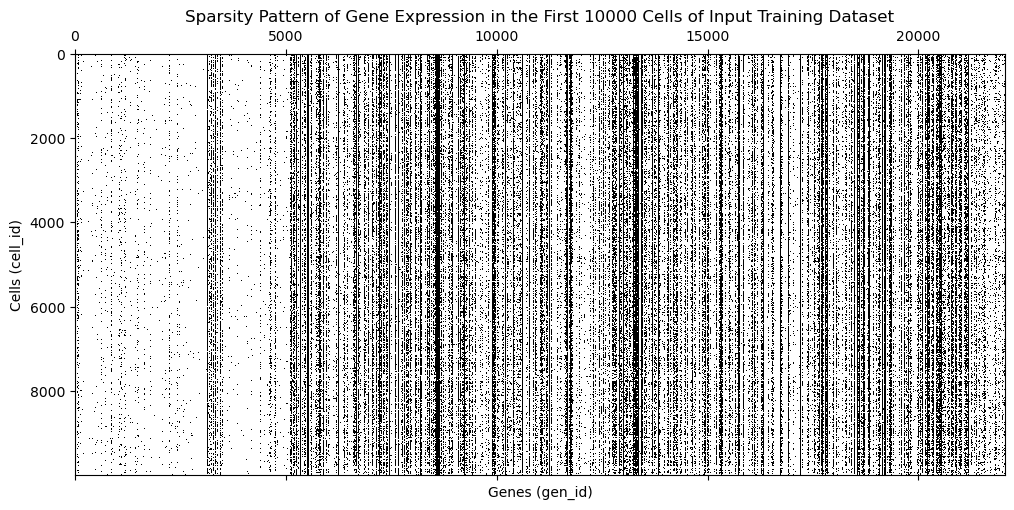

In [91]:
# Plot the sparsity pattern of a the first 10k cells (rows) of input training dataset
# Each dot represents a non-zero value, and the areas without dots represent 0 values
plt.figure(figsize=(12, 6))
plt.spy(data_cite_train_X[:10000])
plt.title('Sparsity Pattern of Gene Expression in the First 10000 Cells of Input Training Dataset')
plt.xlabel('Genes (gen_id)')
plt.ylabel('Cells (cell_id)')
plt.show()

#### To summarize the insights:
- There are no null values in the dataset. 

- The CITEseq training input dataset contains 70988 records (71k), i.e., cells, identified by `cell_id`, and 22050 columns (22k), i.e., the RNA expression level of specific genes determined by `gene_id`, which are RNA library-size normalized (Normalize each cell by total counts over all genes, so that every cell has the same total count after normalization) and log1p transformed ($log1p(x)=log(1+x)$) given by given by {gene_name}_{gene_ensemble-ids}. 

- The feature values are either 0 or between 2.97 and 11.58.

- There are 449 genes (out of the total genes present in the dataset) that are never expressed in any of the cells in the training dataset. In other words, for these 449 genes, the RNA expression level is 0 across all cells.

- 78% of all dataframe entries are 0.

#### Now we look at CITEseq input dataset for testing. 

In [92]:
data_cite_test_X = pd.read_hdf(cite_test_inputs)
data_cite_test_X.head()

gene_id,ENSG00000121410_A1BG,ENSG00000268895_A1BG-AS1,ENSG00000175899_A2M,ENSG00000245105_A2M-AS1,ENSG00000166535_A2ML1,ENSG00000128274_A4GALT,ENSG00000094914_AAAS,ENSG00000081760_AACS,ENSG00000109576_AADAT,ENSG00000103591_AAGAB,...,ENSG00000153975_ZUP1,ENSG00000086827_ZW10,ENSG00000174442_ZWILCH,ENSG00000122952_ZWINT,ENSG00000198205_ZXDA,ENSG00000198455_ZXDB,ENSG00000070476_ZXDC,ENSG00000162378_ZYG11B,ENSG00000159840_ZYX,ENSG00000074755_ZZEF1
cell_id,,,,,,,,,,,,,,,,,,,,,
c2150f55becb,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.00000,0.000000,4.090185,0.0
65b7edf8a4da,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,4.039545,0.0,0.0,0.00000,0.000000,0.000000,0.0
c1b26cb1057b,0.0,0.0,0.0,0.0,0.0,3.847321,0.000000,3.847321,3.847321,0.0,...,0.000000,0.000000,3.847321,4.529743,0.0,0.0,0.00000,3.847321,3.847321,0.0
917168fa6f83,0.0,0.0,0.0,0.0,0.0,0.000000,3.436846,3.436846,0.000000,0.0,...,3.436846,0.000000,4.113780,5.020215,0.0,0.0,0.00000,3.436846,4.113780,0.0
2b29feeca86d,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,4.196826,0.000000,0.0,...,0.000000,4.196826,4.196826,4.196826,0.0,0.0,3.51861,4.196826,3.518610,0.0


In [93]:
data_cite_test_X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 48663 entries, c2150f55becb to ad5a949989b2
Columns: 22050 entries, ENSG00000121410_A1BG to ENSG00000074755_ZZEF1
dtypes: float32(22050)
memory usage: 4.0+ GB


In [94]:
data_cite_test_X.shape

(48663, 22050)

In [95]:
# Count of Genes that never occurs in cells
print('Genes which never occue in train dataset inputs:', (data_cite_test_X == 0).all(axis=0).sum())

Genes which never occue in train dataset inputs: 745


In [96]:
non_zero_min = data_cite_test_X.replace(0, np.nan).min().min()
max_val = data_cite_test_X.max().max()
print(f'Values range from {non_zero_min} to {max_val}')

Values range from 2.6733455657958984 to 12.705485343933105


In [97]:
# Percentage of values in the training input dataset that are o
((data_cite_test_X == 0).sum().sum() / data_cite_test_X.size) * 100

78.14426676355217

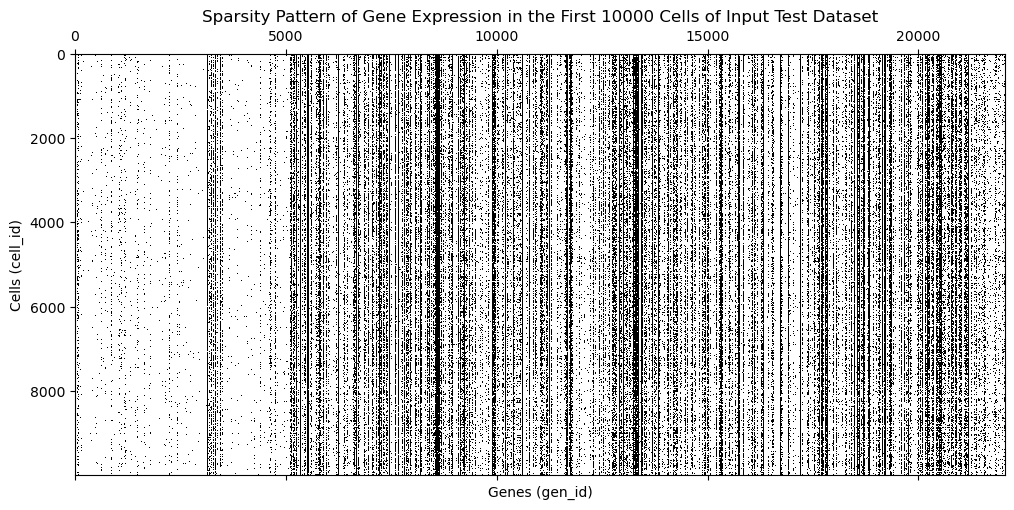

In [98]:
# Plot the sparsity pattern of a the first 10k cells (rows) of input test dataset
# Each dot represents a non-zero value, and the areas without dots represent 0 values
plt.figure(figsize=(12, 6))
plt.spy(data_cite_test_X[:10000])
plt.title('Sparsity Pattern of Gene Expression in the First 10000 Cells of Input Test Dataset')
plt.xlabel('Genes (gen_id)')
plt.ylabel('Cells (cell_id)')
plt.show()

#### Insights:
- There are no null values in the input test data. 

- The CITEseq input test dataset contains 48663 records (48k), i.e., cells, identified by `cell_id`, and 22050 columns (22k), i.e., the RNA expression level of specific genes determined by `gene_id`, which are RNA library-size normalized (Normalize each cell by total counts over all genes, so that every cell has the same total count after normalization) and log1p transformed ($log1p(x)=log(1+x)$) given by given by {gene_name}_{gene_ensemble-ids}. 

- The CITEseq input dataset contain 70988 rows (i.e., `cells`) for train and 48663 rows for test, $70988 + 48663 = 119651$, which matches the number of rows in the CITEseq metadata table. No values are missing. 

- The feature values are either 0 or between 2.67 and 12.71 . 

- There are 745 genes (out of the total genes present in the dataset) that are never expressed in any of the cells in the input test dataset. In other words, for these 745 genes, the RNA expression level is 0 across all cells.

- 78% of all dataframe entries are 0.

### 3.2 CITEseq Target Dataset (Surface Protein levels)

Now we will look at the CTTEseq target dataset for training. 

In [99]:
data_cite_train_y = pd.read_hdf(cite_train_targets)
data_cite_train_y.head()

gene_id,CD86,CD274,CD270,CD155,CD112,CD47,CD48,CD40,CD154,CD52,...,CD94,CD162,CD85j,CD23,CD328,HLA-E,CD82,CD101,CD88,CD224
cell_id,,,,,,,,,,,,,,,,,,,,,
45006fe3e4c8,1.167804,0.622530,0.106959,0.324989,3.331674,6.426002,1.480766,-0.728392,-0.468851,-0.073285,...,-0.448390,3.220174,-0.533004,0.674956,-0.006187,0.682148,1.398105,0.414292,1.780314,0.548070
d02759a80ba2,0.818970,0.506009,1.078682,6.848758,3.524885,5.279456,4.930438,2.069372,0.333652,-0.468088,...,0.323613,8.407108,0.131301,0.047607,-0.243628,0.547864,1.832587,0.982308,2.736507,2.184063
c016c6b0efa5,-0.356703,-0.422261,-0.824493,1.137495,0.518924,7.221962,-0.375034,1.738071,0.142919,-0.971460,...,1.348692,4.888579,-0.279483,-0.131097,-0.177604,-0.689188,9.013709,-1.182975,3.958148,2.868600
ba7f733a4f75,-1.201507,0.149115,2.022468,6.021595,7.258670,2.792436,21.708519,-0.137913,1.649969,-0.754680,...,1.504426,12.391979,0.511394,0.587863,-0.752638,1.714851,3.893782,1.799661,1.537249,4.407671
fbcf2443ffb2,-0.100404,0.697461,0.625836,-0.298404,1.369898,3.254521,-1.659380,0.643531,0.902710,1.291877,...,0.777023,6.496499,0.279898,-0.841950,-0.869419,0.675092,5.259685,-0.835379,9.631781,1.765445


In [100]:
data_cite_train_y.info()

<class 'pandas.core.frame.DataFrame'>
Index: 70988 entries, 45006fe3e4c8 to c91b6b2ccd3d
Columns: 140 entries, CD86 to CD224
dtypes: float32(140)
memory usage: 38.5+ MB


In [101]:
data_cite_train_y.shape

(70988, 140)

We can observe that the CITEseq output (target) file has 70988 rows like the training input file, but only 140 columns. The 140 columns correspond to 140 surface protein levels.

Note that the surface protein levels have been `dsb` (denoised and scaled by background) normalized, which uses background droplets defined by low RNA content in order to estimate background protein signal and remove it from the data [ Korliarov, Sparks et al., 2020](https://www.nature.com/articles/s41591-020-0769-8).

### 3.3 CITEseq Name Matching

The CITEseq task takes `genes` as input and outputs corresponding `proteins`. Gene names contain protein names as suffixes after '_'. For instance, the gene name ENSG00000121410_A1BG contains A1BG as the protein. The input dataframe has genes as column names, and the target dataframe has proteins as column names.


In [116]:
# Match the Input column names with the Target column names
cite_protein_names = list(data_cite_train_y.columns)
match_list = []
for protein in cite_protein_names:
    match_list += [(gene, protein) for gene in cite_gene_names if protein in gene]
gene_protein = pd.DataFrame(match_list, columns=['Gene', 'Protein'])
gene_protein

,Gene,Protein
0,ENSG00000114013_CD86,CD86
1,ENSG00000120217_CD274,CD274
2,ENSG00000196776_CD47,CD47
3,ENSG00000117091_CD48,CD48
4,ENSG00000101017_CD40,CD40
...,...,...
146,ENSG00000102181_CD99L2,CD9
147,ENSG00000223773_CD99P1,CD9
148,ENSG00000204592_HLA-E,HLA-E
149,ENSG00000085117_CD82,CD82


In [119]:
# Duplicates Protein
duplicates_protein = gene_protein[gene_protein['Protein'].duplicated(keep=False)]
duplicates_protein


,Gene,Protein
4,ENSG00000101017_CD40,CD40
5,ENSG00000102245_CD40LG,CD40
7,ENSG00000117528_ABCD3,CD3
8,ENSG00000168014_C2CD3,CD3
9,ENSG00000167851_CD300A,CD3
...,...,...
143,ENSG00000125810_CD93,CD9
144,ENSG00000153283_CD96,CD9
145,ENSG00000002586_CD99,CD9
146,ENSG00000102181_CD99L2,CD9


#### Insights:
- We find `151` genes which encode a target protein. 

- Some proteins are encoded by more than one gene (above dataframe). 

- We may assume that these 151 features will have a high feature importance in our model.